<div style="background-color:#1B79FD; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> XLM(Cross-lingual language model)</div> 
<div style="background-color:#74A9EC; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architecture Overview </div>
<br>
It is a powerful transformer based architecture designed primarily for multilingual natural language processing tasks. It is built on original transformers architecture. The unique building blocks are defined below :

1. Transformer Encoder : XLM utilizes a transformer encoder as its core building block. This encoder is composed of stacked self attention layers and feed forward neural networks. The self attention mechanism allows the model to capture the dependencies between different words in a sentence while feed forward networks provide non linear transformations to the input.

2. Bilingual Training : One of the distinctive aspects of XLM is its training process. It leverages parallel data from multiple languages during training, which helps it learn shared representations across languages. This bilingual training enables the model to transfer knowledge b/w different languages and improve its cross lingual capabilities.

3. Masked Language Model(MLM): Similar to other transformer architectures, XLM employs a masked language model objective during pretraining. This objective involves randomly masking certain tokens in the input and training the model to predict the original tokens based on the context. This task encourages the model to understand the relationships between words and learn meaningful representations.

4. Cross-lingual Language Model(CLM): In addn. to MLM objective, XLM introduces a cross-lingual language model objective. This objective involves training the model to predict words in one language given the context of another language. by using this objective, XLM learns to transfer the knowledge across langs and develop a shared representation space.

5. Language discriminator : XLM includes a language discriminator module to further enhance its cross lingual capabilities. The language discriminator is trained to predict the language of a given text. By jointly training the language discriminator and cross lang model, XLM learns to understand and differentiate b/w multiple languages in a much better way.

6. Unsupervised Training : XLM utilizes unsupervised training methods, which meants that it can learn from large amounts of monolingual and parallel data without requiring explicitly large language annotations. This approach makes it useful for low resource languages where labeled data is scarce.

<div style="background-color:#74A9EC; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architecture Diagram </div>

[View bigger diagram](https://drive.google.com/file/d/1qIdKfkDaj3I_Kv-4t119T8iroi_BYOwi/view?usp=sharing)

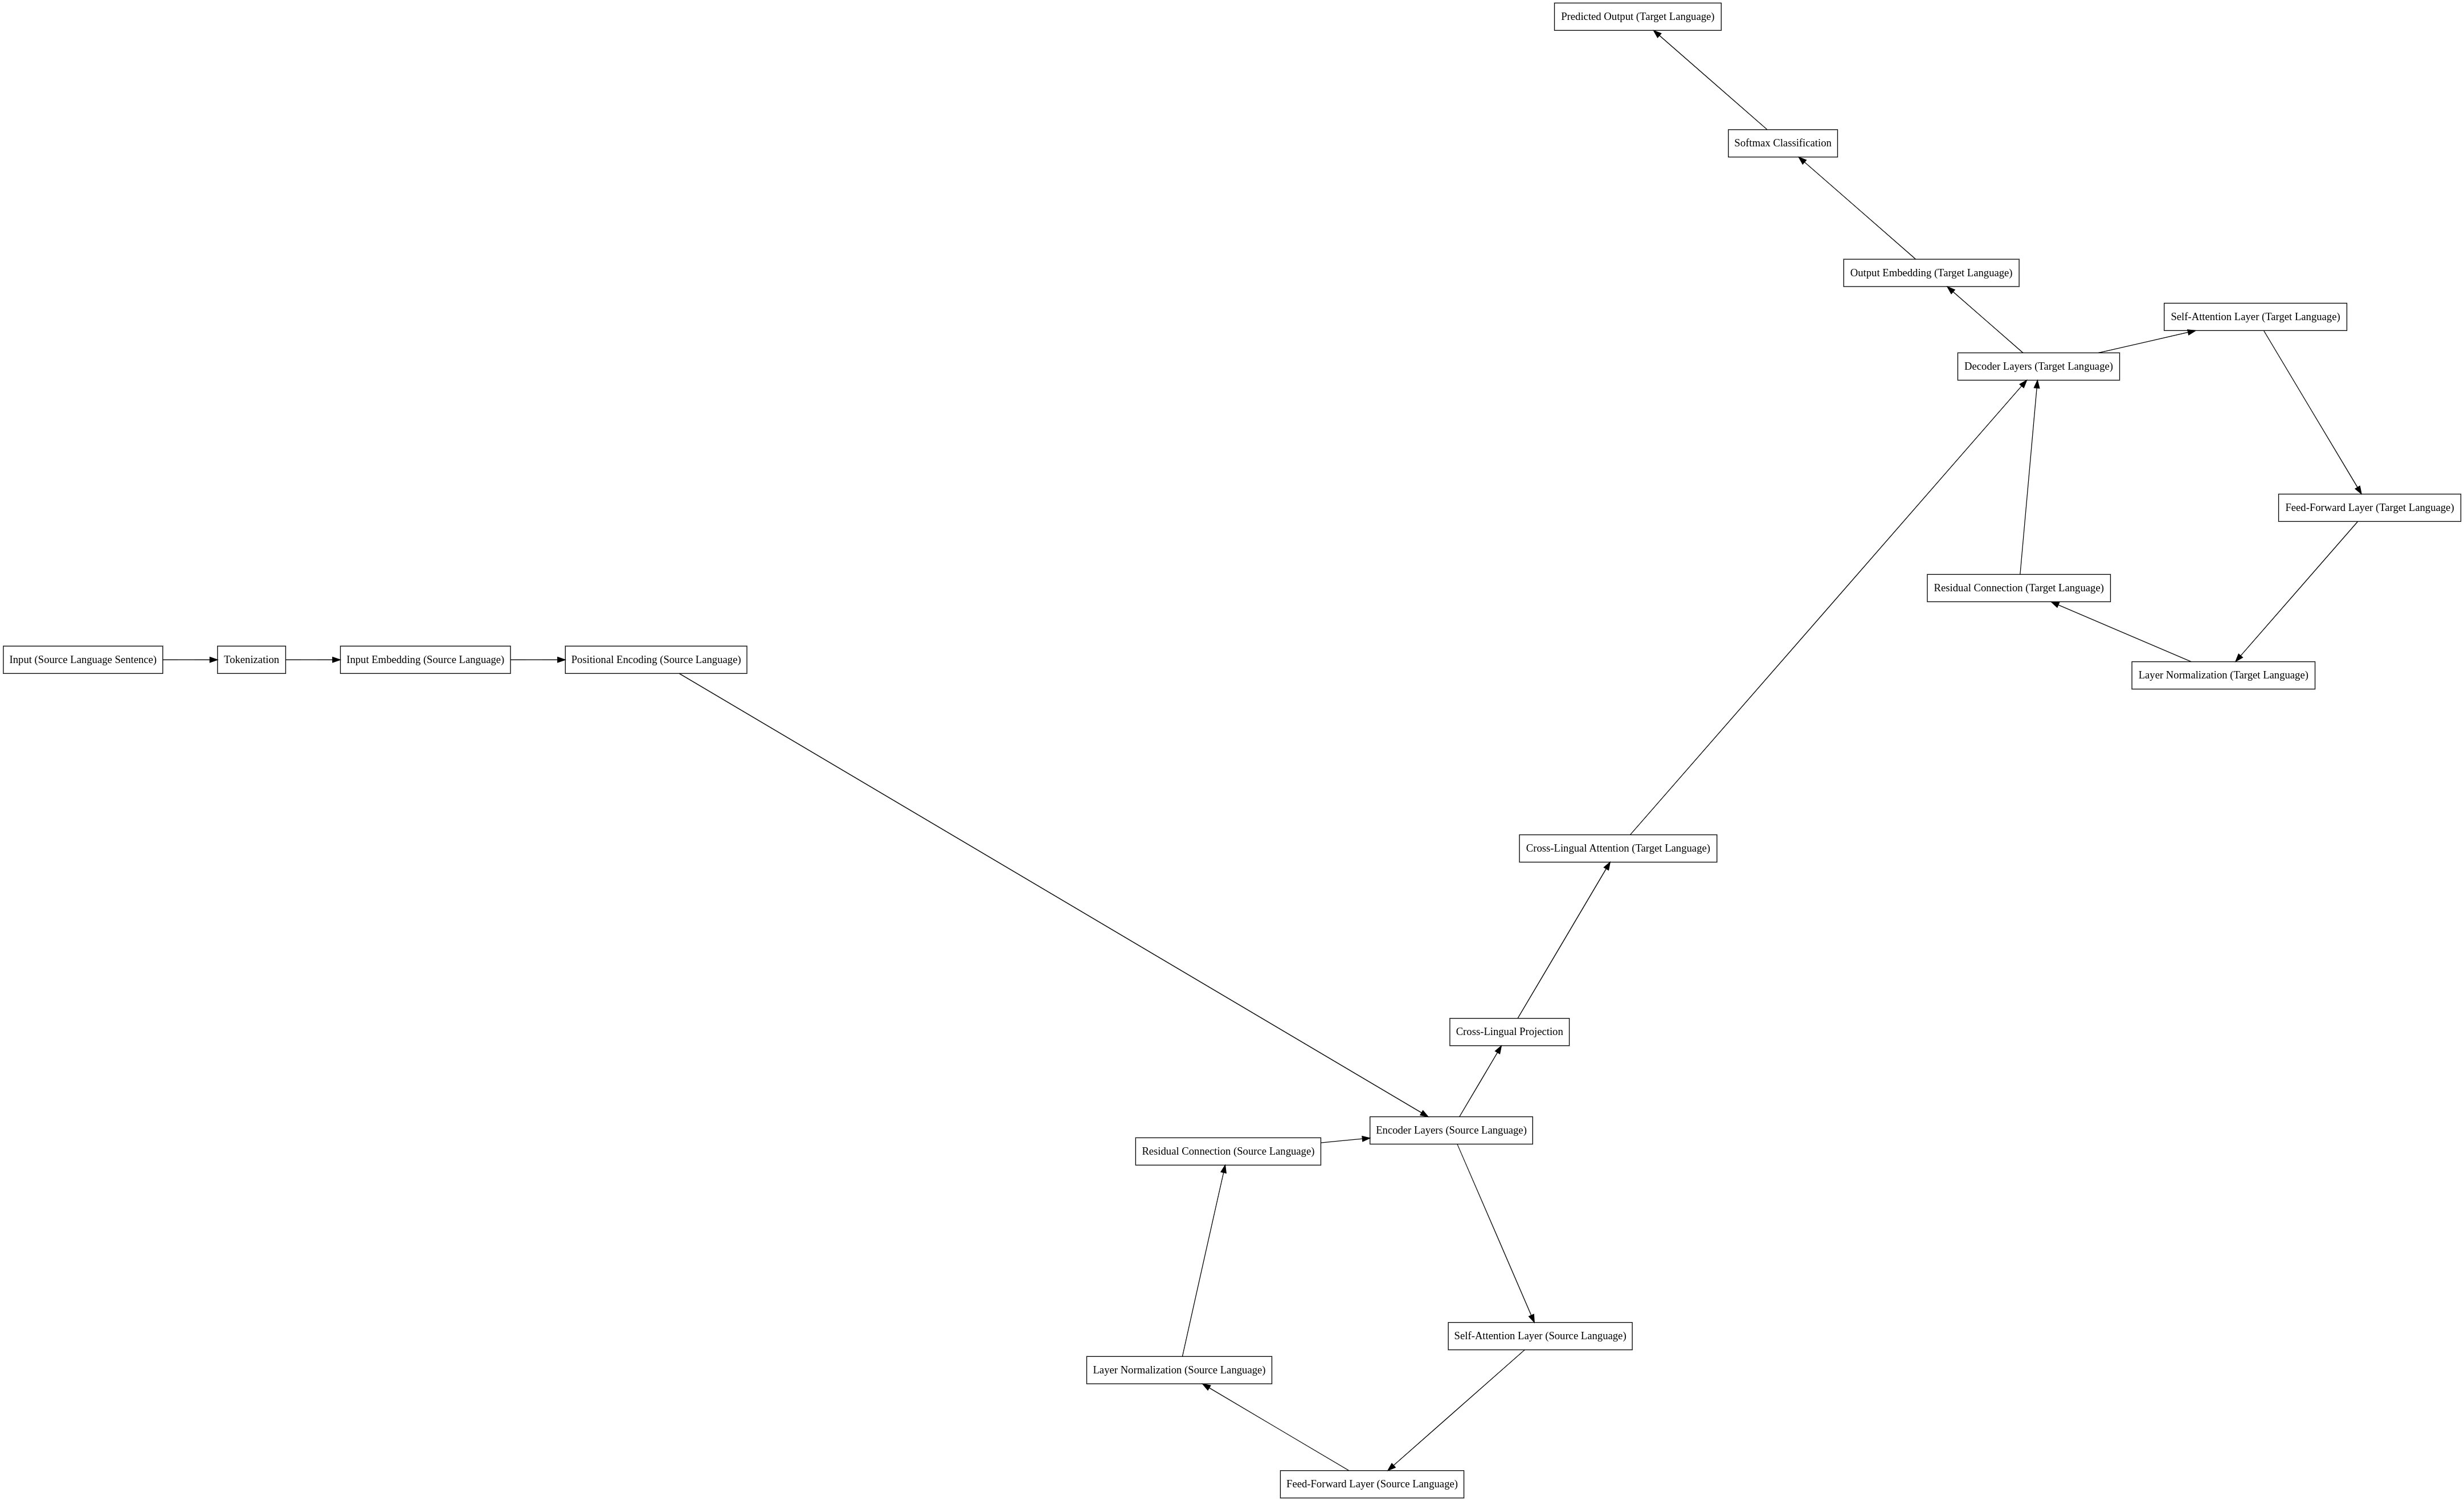

In [31]:
from IPython.display import display
from PIL import Image

image_path = '/kaggle/input/notebook-images/XLM.jpg'

image = Image.open(image_path)

display(image)


In [1]:
!pip install sacremoses --quiet

<div style="background-color:#D4E8FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Importing modules and loading the tokenizer </div>

In [2]:

import torch
import pandas as pd
from torch.utils.data import DataLoader
from transformers import XLMTokenizer, XLMForSequenceClassification, AdamW
from sklearn.metrics import roc_auc_score

# Load the XLM tokenizer
tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-100-1280')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> This code snippet loads the training and validation datasets from CSV files. It then tokenizes the comments in the datasets using a tokenizer. The tokenizer function takes the comment texts as input, performs truncation and padding, and returns the encoded representations of the comments as train_encodings and val_encodings respectively. </div>

In [3]:
train_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv')
val_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv')

train_encodings = tokenizer(train_df.comment_text.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_df.comment_text.tolist(), truncation=True, padding=True)


<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> This code snippet defines a custom PyTorch dataset class called `ToxicCommentDataset` for the training and validation data. The class takes two arguments, `encodings` and `labels`, which are the encoded representations of the comments and their corresponding labels, respectively.<br>
<br>
The `__getitem__` method returns a dictionary of tensors for each encoding key (such as `input_ids`, `attention_mask`, etc.) and the corresponding label tensor for a given index `idx`. The `__len__` method returns the length of the dataset, which is equal to the number of labels.<br> </div>

In [4]:
class ToxicCommentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

    def __len__(self):
        return len(self.labels)

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> These lines of code create instances of the `ToxicCommentDataset` class for the training and validation data. The `train_dataset` is initialized with `train_encodings` (the encoded representations of the training comments) and `train_df.toxic.values` (the corresponding toxic labels). Similarly, the `val_dataset` is initialized with `val_encodings` (the encoded representations of the validation comments) and `val_df.toxic.values` (the corresponding toxic labels).</div>

In [5]:
train_dataset = ToxicCommentDataset(train_encodings, train_df.toxic.values)
val_dataset = ToxicCommentDataset(val_encodings, val_df.toxic.values)


<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> These lines of code create data loaders for the training and validation datasets. The `train_loader` is created using the `DataLoader` class with `train_dataset` as the dataset, a batch size of 4, and `shuffle=True` to randomize the order of samples in each batch during training. Similarly, the `val_loader` is created with `val_dataset` as the dataset, a batch size of 4, and `shuffle=False` to maintain the order of samples during validation. </div>

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Performing sanity check of the dataloader </div>

In [7]:
for batch in train_loader:
    print(batch)
    break

[{'input_ids': tensor([[    0,   205,    30,  ...,     2,     2,     2],
        [    0,    16,  2193,  ...,     2,     2,     2],
        [    0,  1623,   443,  ...,     2,     2,     2],
        [    0, 20312,    31,  ...,     2,     2,     2]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}, tensor([0, 1, 0, 0])]


<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> The first line of code sets the device to use CUDA for GPU acceleration.<br>
<br>
The second line of code loads the XLM model for sequence classification using the `XLMForSequenceClassification` class from the "xlm-mlm-100-1280" pretrained model. The `num_labels` parameter is set to 2, indicating the number of classes in the classification task.<br>
<br>
The third line of code moves the model to the specified device (CUDA) using the `to` method.<br>
<br>
The fourth line of code sets the model to training mode by invoking the `train` method.<br> </div>

In [9]:
device = torch.device("cuda")

model = XLMForSequenceClassification.from_pretrained('xlm-mlm-100-1280', num_labels=2)
model.to(device)
model.train()


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMForSequenceClassification were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

XLMForSequenceClassification(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1280)
    (embeddings): Embedding(200000, 1280, padding_idx=2)
    (layer_norm_emb): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0-15): 16 x MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-15): 16 x LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-15): 16 x TransformerFFN(
        (lin1): Linear(in_features=1280, out_features=5120, bias=True)
        (lin2): Linear(in_features=5120, out_features=1280, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): ModuleList(

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"><br> The first line of code initializes the AdamW optimizer with the parameters of the `model`. The learning rate (`lr`) is set to 5e-5.
<br>
The second line of code creates a step-based learning rate scheduler using the `StepLR` class from `torch.optim.lr_scheduler`. The scheduler is associated with the `optimizer` and has a step size of 1. After each step, the learning rate will be multiplied by the specified `gamma` value of 0.1.<br> </div>

In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> This code snippet performs a training loop for 2 epochs. You can increase the training for more epochs to obtain higher accuracy. <br>
<br>
Within each epoch, it iterates over the batches in the `train_loader` using the `tqdm` function for progress tracking. <br>
<br>
For each batch, it moves the input data (`input_ids`, `attention_mask`, `labels`) to the device (CUDA). <br>
<br>
Then, it zeros the gradients, performs a forward pass through the model, calculates the loss, and performs a backward pass and optimizer step to update the model parameters.<br>
<br>
After each batch, if the step number is divisible by 100, it prints the current step number and the corresponding loss.<br>
<br>
Then, it switches the model to evaluation mode (`model.eval()`) and performs inference on the validation dataset (`val_loader`) using a similar loop structure. It computes probabilities using softmax and selects the predicted class label. The predicted labels and true labels are accumulated to calculate the ROC AUC score for validation (`val_auc`).<br>
<br>
Finally, it prints the validation AUC score for each epoch, and the learning rate scheduler is updated with `scheduler.step()` at the end of each epoch to adjust the learning rate based on the predefined step size and gamma values.<br> </div>

In [16]:
from tqdm import tqdm
for epoch in range(2):
    for step,batch in tqdm(enumerate(train_loader)):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)
        labels = batch[1].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Backward pass
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
    if step%100==0:
        print("Step-{},Loss-{}".format(step,loss.item()))

    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
            # Move the batch to the device
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)
            _, predicted = torch.max(probabilities, dim=1)

            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_auc = roc_auc_score(val_labels, val_predictions)

    print(f'Epoch {epoch + 1}: Validation AUC = {val_auc}')

    scheduler.step()
#keyboard interrupt --> intentional since train time is higher, you may uncomment and train for more.

115it [01:22,  1.40it/s]


KeyboardInterrupt: 

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> <br>This code snippet loads the test dataset from a CSV file and tokenizes the comments in the test dataset using the same tokenizer as before. The resulting encodings are stored in `test_encodings`.<br>
<br>
A PyTorch dataset for the test data is created using the `ToxicCommentDataset` class with `test_encodings` as the encodings and a list of zeros with the length of the test dataset as the labels.<br>
<br>
A data loader for the test data is defined using the `DataLoader` class, with `test_dataset` as the dataset, a batch size of 32, and `shuffle=False` to maintain the order of samples.<br>
<br>
Finally, the model is switched to evaluation mode using `model.eval()`.<br> </div>

In [19]:
test_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test_encodings = tokenizer(test_df.content.tolist(), truncation=True, padding=True)

test_dataset = ToxicCommentDataset(test_encodings, [0] * len(test_df))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()


XLMForSequenceClassification(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1280)
    (embeddings): Embedding(200000, 1280, padding_idx=2)
    (layer_norm_emb): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0-15): 16 x MultiHeadAttention(
        (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
        (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-15): 16 x LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-15): 16 x TransformerFFN(
        (lin1): Linear(in_features=1280, out_features=5120, bias=True)
        (lin2): Linear(in_features=5120, out_features=1280, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): ModuleList(

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> This code snippet creates an empty list called `predictions` to store the predicted classes.<br>
<br>
Then, it iterates over the test dataset (`test_loader`) using the `tqdm` function for progress tracking.<br>
<br>
For each batch in the test dataset, it moves the input data (`input_ids`, `attention_mask`) to the device (CUDA).<br>
<br>
Next, it performs inference on the model by passing the input data through the model. It computes the probabilities using softmax and selects the predicted class label.
<br>
The predicted classes are appended to the `predictions` list by extending it with the numpy array of predicted labels converted to CPU.<br>
<br>
After the loop completes, the `predictions` list will contain all the predicted classes for the test dataset.<br> </div>

In [21]:
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=1)
        _, predicted = torch.max(probabilities, dim=1)

        predictions.extend(predicted.cpu().numpy())
#keyboard interrupt --> intentional since inference time is higher, you may uncomment and infer.

 12%|█▏        | 230/1995 [07:08<54:51,  1.86s/it] 


KeyboardInterrupt: 

<div style="background-color:#D4E8FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> This code snippet creates a DataFrame called `submission_df` with two columns: 'id' and 'toxic'. The 'id' column contains the corresponding IDs from the test dataset, and the 'toxic' column contains the predicted classes stored in the `predictions` list.<br>
<br>
Then, it saves the `submission_df` DataFrame to a CSV file named 'submission.csv' using the `to_csv` method. The `index=False` parameter ensures that the row indices are not included in the CSV file. <br></div>

In [ ]:
# Create a dataframe with the predictions
submission_df = pd.DataFrame({'id': test_df.id, 'toxic': predictions})

# Save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df